In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
#from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
K.set_image_data_format("channels_last")
from livelossplot import PlotLossesKeras

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
# fixar random seed para se puder reproduzir os resultados
seed = 9
np.random.seed(seed)

In [3]:
# Atributos de entrada estão com matrizes 3D(imagem, largura, altura) e os atributos de saída é uma lista com o número correspondente
def load_fashion_mnist_dataset():
    from keras.datasets import fashion_mnist
    ((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()
    return (x_train, y_train), (x_test, y_test)


# util para visualizar a topologia da rede num ficheiro em pdf ou png
def print_model(model, fich):
    from keras.utils import plot_model
    plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)


# utils para visualização do historial de aprendizagem
def print_history_accuracy(history):
    print(history.history.keys())
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def print_history_loss(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def create_compile_model_cnn_simples(num_classes):
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    return model


def create_compile_model_cnn_plus(num_classes):
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    return model


def fashion_mnist_utilizando_cnn_simples():
    (X_train, y_train), (X_test, y_test) = load_fashion_mnist_dataset()

    # transformar para o formato [instancias][largura][altura][pixeis]
    # (60000, 28, 28)
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
    # (60000, 28, 28, 1)

    # normalizar os valores dos pixeis de 0-255 para 0-1
    X_train = X_train / 255
    X_test = X_test / 255

    # transformar o label que é um inteiro em categorias binárias, o valor passa a ser ocorrespondente à posição
    # o 5 passa a ser a lista [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]

    # definir a topologia da rede e compilar
    model = create_compile_model_cnn_simples(num_classes)
    #print(model.summary())
    print_model(model, "model_fashion_mnist_cnn_simples.png")
    plotlosses = PlotLossesKeras()

    # treinar a rede
    history = model.fit(X_train, y_train, validation_data=(
        X_test, y_test), epochs=10, batch_size=200, verbose=2, callbacks=[PlotLossesKeras()])
    
    #print_history_accuracy(history)
    #print_history_loss(history)

    # Avaliação final com os casos de teste
    scores = model.evaluate(X_test, y_test, verbose=0)
    #print('Scores: ', scores)
    print("Accuracy modelo CNN fashion mnist simples: %.2f%%" % (scores[1]*100))
    print("Erro modelo CNN fashion mnist simples: %.2f%%" % (100-scores[1]*100))


def fashion_mnist_utilizando_cnn_plus():
    (X_train, y_train), (X_test, y_test) = load_fashion_mnist_dataset()

    # transformar para o formato [instancias][largura][altura][pixeis]
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

    # normalizar os valores dos pixeis de 0-255 para 0-1
    X_train = X_train / 255
    X_test = X_test / 255

    # transformar o label que é um inteiro em categorias binárias, o valor passa a ser o correspondente à posição
    # o 5 passa a ser a lista [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]

    # definir a topologia da rede e compilar
    model = create_compile_model_cnn_plus(num_classes)
    #print(model.summary())
    print_model(model, "model_fashion_mnist_cnn_plus.png")
    plotlosses = PlotLossesKeras()

    # treinar a rede
    history = model.fit(X_train, y_train, validation_data=(
        X_test, y_test), epochs=10, batch_size=200, verbose=2, callbacks=[PlotLossesKeras()])
    #print_history_accuracy(history)
    #print_history_loss(history)

    # Avaliação final com os casos de teste
    scores = model.evaluate(X_test, y_test, verbose=0)
    #print('Scores: ', scores)
    print("Accuracy modelo CNN fashion mnist plus: %.2f%%" % (scores[1]*100))
    print("Erro modelo CNN fashion mnist plus: %.2f%%" % (100-scores[1]*100))

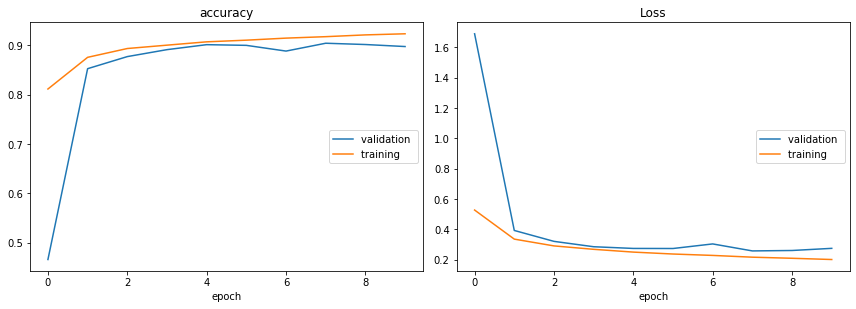

accuracy
	validation       	 (min:    0.466, max:    0.904, cur:    0.897)
	training         	 (min:    0.811, max:    0.923, cur:    0.923)
Loss
	validation       	 (min:    0.258, max:    1.689, cur:    0.275)
	training         	 (min:    0.202, max:    0.528, cur:    0.202)
Accuracy modelo CNN fashion mnist plus: 89.75%
Erro modelo CNN fashion mnist plus: 10.25%
Tempo processamento: 473.514 segundos


In [4]:
if __name__ == '__main__':
    start_time = time.time()
    #fashion_mnist_utilizando_cnn_simples()
    fashion_mnist_utilizando_cnn_plus()
    time_taken = time.time() - start_time
    print("Tempo processamento: %.3f segundos" % (time_taken))